# Quick start

First, lets just run through some examples to see where we are going
by simulating a simple example population which we observe as a
survey. Let's say we are in a giant sphere surrounded by fire flies
that fill the volume homogeneously. Furthermore, the light they emit
follows a Pareto distribution (power law) in luminosity. Of course,
this population can be anything; active galactic nuclei (AGN),
gamma-ray bursts (GRBs), etc. The framework provided in popsynth is
intended to be generic.

In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)
purple = "#B833FF"
yellow = "#F6EF5B"

import popsynth

popsynth.update_logging_level("INFO")

import networkx as nx
import numpy as np
import warnings

warnings.simplefilter("ignore")

In [2]:
class DemoSampler(popsynth.AuxiliarySampler):
    _auxiliary_sampler_name = "DemoSampler"
    mu = popsynth.auxiliary_sampler.AuxiliaryParameter(default=2)
    tau = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1, vmin=0)

    def __init__(self):

        super(DemoSampler, self).__init__("demo", observed=False)

    def true_sampler(self, size):

        self._true_values = np.random.normal(self.mu, self.tau, size=size)


class DemoSampler2(popsynth.DerivedLumAuxSampler):
    _auxiliary_sampler_name = "DemoSampler2"
    mu = popsynth.auxiliary_sampler.AuxiliaryParameter(default=2)
    tau = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1, vmin=0)
    sigma = popsynth.auxiliary_sampler.AuxiliaryParameter(default=1, vmin=0)

    def __init__(self):

        super(DemoSampler2, self).__init__("demo2")

    def true_sampler(self, size):

        secondary = self._secondary_samplers["demo"]

        self._true_values = (
            (np.random.normal(self.mu, self.tau, size=size))
            + secondary.true_values
            - np.log10(1 + self._distance)
        )

    def observation_sampler(self, size):

        self._obs_values = self._true_values + np.random.normal(
            0, self.sigma, size=size
        )

    def compute_luminosity(self):

        secondary = self._secondary_samplers["demo"]

        return (10 ** (self._true_values + 54)) / secondary.true_values

## A spherically homogenous population of fire flies with a pareto luminosity function

**popsynth** comes with several types of populations included, though
you can easily [construct your
own](https://popsynth.readthedocs.io/en/latest/notebooks/custom.html). To
access the built in population synthesizers, one simply instantiates
the population from the **popsynth.populations** module. Here, we will
simulate a survey that has a homogenous spherical spatial distribution
and a pareto distributed luminosity.

In [3]:
homogeneous_pareto_synth = popsynth.populations.ParetoHomogeneousSphericalPopulation(
    Lambda=5, Lmin=1, alpha=2.0  # the density normalization  # lower bound on the LF
)  # index of the LF

print(homogeneous_pareto_synth)

Luminosity Function
pareto
\frac{\alpha L_{\rm min}^{\alpha}}{L^{\alpha+1}}
Lmin: 1
alpha: 2.0
Spatial Function
cons_sphere
\Lambda
Lambda: 5
r_max: 5



In [4]:
homogeneous_pareto_synth.display()


## Luminosity Function

<IPython.core.display.Math object>

parameter  value
0      Lmin    1.0
1     alpha    2.0

## Spatial Function

<IPython.core.display.Math object>

parameter  value
0    Lambda      5
1     r_max      5

If you have [networkx](https://networkx.org) and
[graviz](https://graphviz.readthedocs.io/en/stable/), you can plot a
graph of the connections.

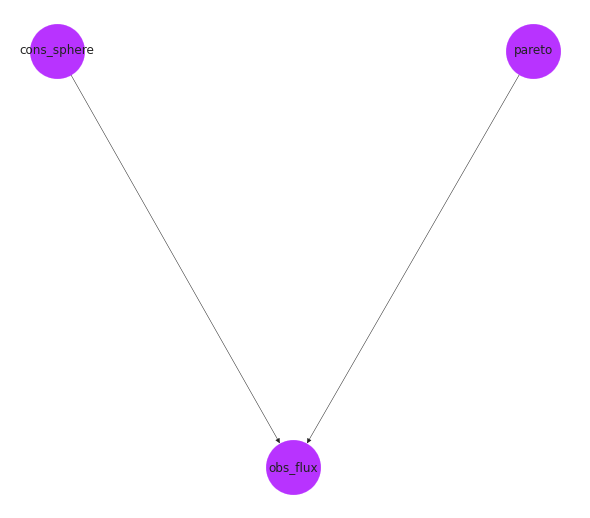

In [5]:
# we can also display a graph of the object


options = {"node_color": purple, "node_size": 3000, "width": 0.5}

pos = nx.drawing.nx_agraph.graphviz_layout(homogeneous_pareto_synth.graph, prog="dot")

nx.draw(homogeneous_pareto_synth.graph, with_labels=True, pos=pos, **options)

## Creating a survey

We can now sample from this population with the **draw_survey**
function, but first we need specify how the flux is selected by adding
a flux selection function. Here, we will use a hard selection function
in this example, but you [can make your
own](https://popsynth.readthedocs.io/en/latest/notebooks/selections.html#custom-selections). The
selection function will mark objects with **observed** fluxes below
the selection boundary as "hidden", but we will still have access to
them in our population. 

In [6]:
flux_selector = popsynth.HardFluxSelection()
flux_selector.boundary = 1e-2

homogeneous_pareto_synth.set_flux_selection(flux_selector)

And by observed fluxes, we mean those where the latent flux is obscured by observational error, here we sample the observational error from a log normal distribution with $\sigma=1$. In the future, ```popsynth``` will have more options.

In [7]:
population = homogeneous_pareto_synth.draw_survey(flux_sigma=0.1)

 INFO     |  The volume integral is 2617.9938779914946 


Drawing distances:   0%|          | 0/2567 [00:00<?, ?it/s]

 INFO     |  Expecting 2567 total objects 


 INFO     |  applying selection to fluxes 


 INFO     |  Detected 573 distances 


 INFO     |  Detected 573 objects out to a distance of 4.99 


We now have created a population survey. How did we get here?

* Once the spatial and luminosity functions are specified, we can integrate out to a given distance and compute the number of expected objects.

* A Poisson draw with this mean is made to determine the number of total objects in the survey.

* Next all quantities are sampled (distance, luminosity)

* If needed, the luminosity is converted to a flux with a given observational error

* The selection function (in this case a hard cutoff) is applied

* A population object is created

We could have specified a soft cutoff (an inverse logit) with logarithmic with as well:

In [8]:
homogeneous_pareto_synth.clean()
flux_selector = popsynth.SoftFluxSelection()
flux_selector.boundary = 1e-2
flux_selector.strength = 20


homogeneous_pareto_synth.set_flux_selection(flux_selector)

population = homogeneous_pareto_synth.draw_survey(flux_sigma=0.1)

 WARNING  |  removing all registered Auxiliary Samplers 


 WARNING  |  removing flux selector 


 WARNING  |  removing distance selector 


 WARNING  |  removing spatial selector 


 INFO     |  The volume integral is 2617.9938779914946 


Drawing distances:   0%|          | 0/2567 [00:00<?, ?it/s]

 INFO     |  Expecting 2567 total objects 


 INFO     |  applying selection to fluxes 


 INFO     |  Detected 609 distances 


 INFO     |  Detected 609 objects out to a distance of 4.99 


More detail on the [process behind the
simulation](https://popsynth.readthedocs.io/en/latest/notebooks/distributions.html#Core-Concept)
can be found deeper in the documentation

## The Population Object

The population object stores all the information about the sampled
survey. This includes information on the latent parameters, measured
parameters, and distances for both the selected and non-selected
objects.

We can have a look at the flux-distance distribution from the
survey. Here, yellow dots are the *latent* flux value, i.e., without
observational noise, and purple dots are the *measured values for the
*selected* objects. Arrows point from the latent to measured values.

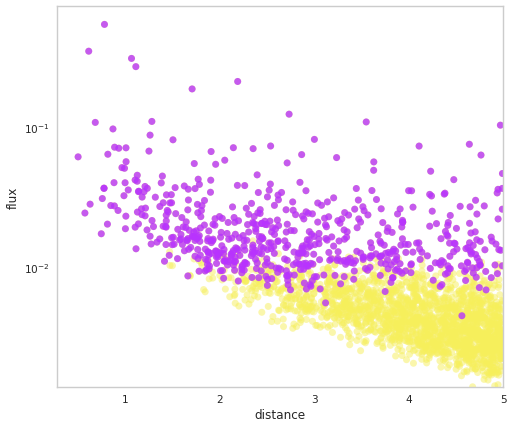

In [9]:
fig = population.display_fluxes(obs_color=purple, true_color=yellow)

For fun, we can display the fluxes on in a simulated universe in 3D

In [10]:
fig = population.display_obs_fluxes_sphere(background_color="black")

The population object stores a lot of information. For example, an array of selection booleans:

In [11]:
population.selection

array([False, False, False, ..., False, False, False])

Every variable that is simulated is stored as a `SimulatedVariable` object. This
object acts as a normal numpy array with a few special properties. The main view
of the array are the **observed** values. These are values that can be obscured
from the **latent** values by measurement error.

Let's examine the observed flux.

In [12]:

# the observed values

population.fluxes

# the latent values

population.fluxes.latent


array([0.00407874, 0.00411367, 0.00478737, ..., 0.00253392, 0.00445139,
       0.00333201])

Any math operation on the a simulated variable is applied to the latent values
as well. Thus, it is easy to manipulate both in one operation. When a variable
is not marked as observed, this implies that the **latent** (true) values and
the **observed** values will be the same. Thus, the values stored will be the
same.

To access the selected or non-selected values of a variable:

In [13]:

selected_fluxes = population.fluxes.selected

non_selected_fluxes = population.fluxes.non_selected



This returns another `SimulatedVaraible` object which allows access to the
latent and observed values as well.


We can retrieve selected and non-selected distances:

In [14]:
distances = population.distances.selected

In [15]:
hidden_distances = population.distances.non_selected

Text(0.5, 0, 'z')

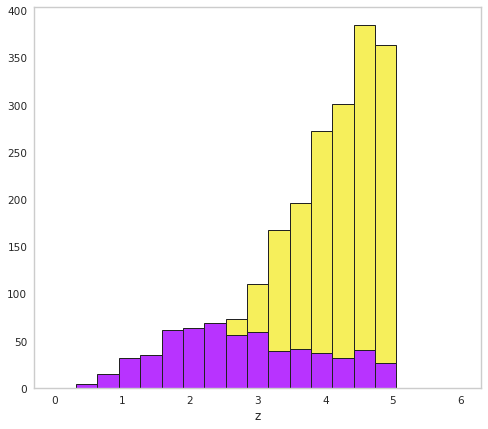

In [16]:
fig, ax = plt.subplots()

bins = np.linspace(0, 6, 20)


ax.hist(hidden_distances, bins=bins, fc=yellow, ec="k",lw=1)
ax.hist(distances, bins=bins, fc=purple, ec="k",lw=1)
ax.set_xlabel("z")


## Saving the population
We can record the results of a population synth to an HDF5 file that
maintains all the information from the run. The true values of the
population parameters are always stored in the truth dictionary:


In [17]:
population.truth

{'cons_sphere': {'Lambda': 5, 'r_max': 5}, 'pareto': {'Lmin': 1, 'alpha': 2.0}}

In [18]:
population.writeto("saved_pop.h5")

In [19]:
reloaded_population = popsynth.Population.from_file("saved_pop.h5")

In [20]:
reloaded_population.truth

{'cons_sphere': {'Lambda': 5, 'r_max': 5}, 'pareto': {'Lmin': 1, 'alpha': 2.0}}

## Creating populations from YAML files

It is sometimes easier to quickly write down population in a YAML file
without having to create all the objects in python. Let's a take a
look at the format:

```yaml

# the seed
seed: 1234

# specifiy the luminosity distribution
# and it's parmeters
luminosity distribution:
    ParetoDistribution:
        Lmin: 1e51
        alpha: 2

# specifiy the flux selection function
# and it's parmeters
flux selection:
    HardFluxSelection:
        boundary: 1e-6

# specifiy the spatial distribution
# and it's parmeters

spatial distribution:
    ZPowerCosmoDistribution:
        Lambda: .5
        delta: -2
        r_max: 5

# specify the distance selection function
# and it's parmeters
distance selection:
    BernoulliSelection:
        probability: 0.5

# a spatial selection if needed
spatial selection:
    # None


# all the auxiliary functions
# these must be known to the
# registry at run time if
# the are custom!

auxiliary samplers:
    stellar_mass
        type: NormalAuxSampler
        observed: False
        mu: 0
        sigma: 1
        selection:
        secondary:
        init variables:

    demo:
        type: DemoSampler
        observed: False
        selection:
            UpperBound:
                boundary: 20

    demo2:
        type: DemoSampler2
        observed: True
        selection:
        secondary: [demo, stellar_mass] # other samplers that this sampler depends on


```

We can load this yaml file into a population synth. We use a saved file to demonstrate:

In [21]:
my_file = popsynth.utils.package_data.get_path_of_data_file("pop.yml")

ps = popsynth.PopulationSynth.from_file(my_file)

print(ps)

 INFO     |  registering derived luminosity sampler: demo2 


Luminosity Function
demo2
observed: True
demo
stellar_mass
Spatial Function
zpow_cosmo
\Lambda (z+1)^{\delta}
Lambda: 0.5
delta: -2.0
r_max: 5.0
demo
observed: False
parents: ['demo2']
stellar_mass
observed: False
mu: 0.0
sigma: 1.0
parents: ['demo2']



In [22]:
ps.display()

## Luminosity Function

Empty DataFrame
Columns: [parameter, value]
Index: []

## Spatial Function

<IPython.core.display.Math object>

parameter  value
0    Lambda    0.5
1     delta   -2.0
2     r_max    5.0

## demo

Empty DataFrame
Columns: [parameter, value]
Index: []

## stellar_mass

parameter  value
0        mu    0.0
1     sigma    1.0

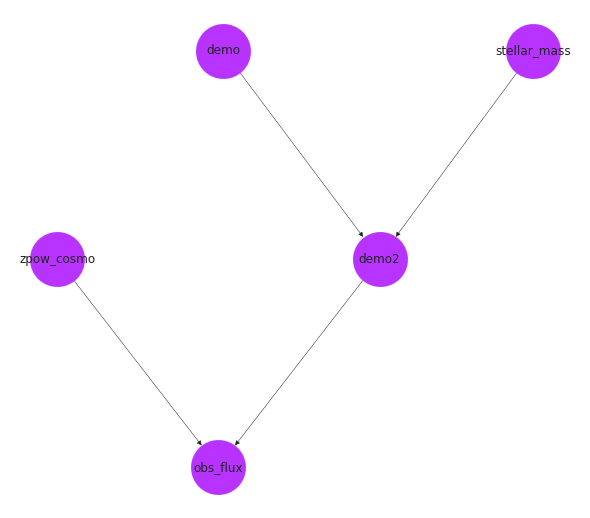

In [23]:
options = {"node_color": purple, "node_size": 3000, "width": 0.5}

pos = nx.drawing.nx_agraph.graphviz_layout(ps.graph, prog="dot")

nx.draw(ps.graph, with_labels=True, pos=pos, **options)

We can see that our population was created correctly for us.


Now, this means we can easily pass populations around to our collaborators for testing

In [24]:
pop = ps.draw_survey(flux_sigma=0.5)

 INFO     |  The volume integral is 3.5702831713758014 


Drawing distances:   0%|          | 0/5 [00:00<?, ?it/s]

 INFO     |  Expecting 5 total objects 


 INFO     |  Sampling: demo2 


 INFO     |  demo2 is sampling its secondary quantities 


 INFO     |  Sampling: demo 


 INFO     |  Sampling: stellar_mass 


 INFO     |  Getting luminosity from derived sampler 


 INFO     |  applying selection to fluxes 


 INFO     |  Applying selection from demo which selected 5 of 5 objects 


 INFO     |  Before auxiliary selection there were 5 objects selected 


 WARNING  |  NO HIDDEN OBJECTS 


Selecting Bernoulli:   0%|          | 0/5 [00:00<?, ?it/s]

 INFO     |  Detected 3 distances 


 INFO     |  Detected 5 objects out to a distance of 3.37 


Now, since we can read the population synth from a file, we can also write one we have created with classes to a file:

In [25]:
ps.to_dict()

{'seed': 1234,
 'spatial distribution': {'ZPowerCosmoDistribution': {'Lambda': 0.5,
   'delta': -2.0,
   'r_max': 5.0},
  'is_rate': True},
 'luminosity distribution': {'ParetoDistribution': {'Lmin': 1e+51,
   'alpha': 2.0}},
 'flux selection': {'HardFluxSelection': {'boundary': 1e-06}},
 'distance selection': {'BernoulliSelection': {'probability': 0.5}},
 'auxiliary samplers': {}}

In [26]:
ps.write_to("/tmp/my_pop_synth.yml")

but our population synth is also serialized to our population!

In [27]:
pop.pop_synth

{'seed': 1234,
 'spatial distribution': {'ZPowerCosmoDistribution': {'Lambda': 0.5,
   'delta': -2.0,
   'r_max': 5.0},
  'is_rate': True},
 'luminosity distribution': {'ParetoDistribution': {'Lmin': 1e+51,
   'alpha': 2.0}},
 'flux selection': {'HardFluxSelection': {'boundary': 1e-06}},
 'distance selection': {'BernoulliSelection': {'probability': 0.5}},
 'auxiliary samplers': {}}

Therefore we always know exactly how we simulated our data.